# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform.


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations.


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.


In [ ]:
# from unittest.mock import inplace

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from traitlets import This

import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
print(df)

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.


In [ ]:
def convert_datatype():
    """
    We want to convert some data type of columns for manipulating
    :return: None
    """
    df['article_id'] = df['article_id'].astype(str)


convert_datatype()



# 50% of individuals interact with ____ number of articles or fewer.
median_val = df.groupby(['email'])['article_id'].count().median()

# The maximum number of user-article interactions by any 1 user is
max_views_by_user = df.groupby(['email'])['article_id'].count().max()


# Find and explore duplicate articles
dup_indices = df_content[df_content.duplicated(subset = ['article_id'])].index
df_content.drop(dup_indices, axis=0, inplace=True)

In [ ]:
# The number of unique articles that have at least one interaction
unique_articles = len(df['article_id'].unique())

# The number of unique articles on the IBM platform
total_articles = len(df_content['article_id'].unique())

# The number of unique users
unique_users = len(df[~df['email'].isnull()]['email'].unique())

# The number of user-article interactions
user_article_interactions = df.shape[0]



`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).


In [ ]:
# The most viewed article in the dataset was viewed how many times?
article_counts = df.groupby(['article_id'])['email'].count()

max_views = article_counts.max()

# The most viewed article in the dataset as a string with one value following the decimal
most_viewed_article_id = article_counts[article_counts == max_views].index[0]

In [ ]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []

    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1

        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

In [ ]:
## If you stored all your results in the variable names above,
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.


In [ ]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook

    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles

    '''
    # Your code here

    top_article_ids = get_top_article_ids(n, df)
    top_articles = df[df['article_id'].isin(top_article_ids)]['title'].unique()
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook

    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles

    '''
    # Your code here

    top_articles = df.groupby(['article_id'])['user_id'].count().sort_values(ascending=False).nlargest(n).index
    # top_articles = df[df['article_id'].isin(_article_counts)]['title'].unique()
    return top_articles # Return the top article ids

In [ ]:
print(get_top_articles(10))
print(get_top_article_ids(10))

In [ ]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**.

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.


In [ ]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns

    OUTPUT:
    user_item - user item matrix

    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with
    an article and a 0 otherwise
    '''
    # Fill in the function here
    user_item = df.groupby(['user_id', 'article_id'])['title'].count().unstack()
    user_item.fillna(0, inplace=True)
    # np.where(user_item >= 1, 1, 0)
    for col in user_item.columns:
        user_item[col] = user_item[col].apply(lambda c: 1 if c > 1 else c)

    return user_item # return the user_item matrix

user_item = create_user_item_matrix(df)

In [ ]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users.

Use the tests to test your function.


In [ ]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles:
                1's when a user has interacted with an article, 0 otherwise

    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first

    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered

    '''
    # compute similarity of each user to the provided user
    sim_dict ={other: np.dot(user_item.loc[user_id], user_item.loc[other]) for other in user_item.index}

    # sort by similarity
    sim_dict = dict(sorted(sim_dict.items(), key=lambda x: x[1], reverse=True))

    # create list of just the ids
    most_similar_users = list(sim_dict.keys())

    # remove the own user's id
    most_similar_users.remove(user_id)

    return most_similar_users # return a list of the users in order from most to least similar

In [ ]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user.


In [ ]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook

    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids
                    (this is identified by the title column)
    '''
    # Your code here

    article_names = df[df['article_id'].isin(article_ids)]['title'].unique()

    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles:
                1's when a user has interacted with an article, 0 otherwise

    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids
                    (this is identified by the doc_full_name column in df_content)

    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    article_ids = list(user_item.loc[user_id][user_item.loc[user_id] > 0].index)

    article_names = get_article_names(article_ids, df=df)


    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user

    OUTPUT:
    recs - (list) a list of recommendations for the user

    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found

    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user

    For the user where the number of recommended articles starts below m
    and ends exceeding m, the last items are chosen arbitrarily

    '''
    # Your code here

    count_recs = 0
    recs = []
    most_similar_users = find_similar_users(user_id, user_item=user_item)

    for sim_user in most_similar_users:

        sim_article_ids, sim_article_names = get_user_articles(sim_user, user_item=user_item)
        for _art_id, _art_name in zip(sim_article_ids, sim_article_names):
            if user_item.loc[user_id, _art_id] == 0.0:
                count_recs += 1
                recs.append(_art_id)

                if count_recs >= m:
                    return recs


    return recs # return your recommendations for this user_id

In [ ]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1


In [ ]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.


In [ ]:
nei_ids = list(user_item.index)
nei_sims = [np.dot(user_item.loc[1], user_item.loc[nei_id]) for nei_id in nei_ids]
nei_views = [np.sum(user_item.loc[nei_id]) for nei_id in nei_ids]

neighbors_df = pd.DataFrame.from_dict({
    'nei_id': nei_ids,
    'nei_sim': nei_sims,
    'nei_view': nei_views

})

neighbors_df.sort_values(by=['nei_sim', 'nei_view'], ascending=[False, False], inplace=True)

neighbors_df.drop(neighbors_df[neighbors_df['nei_id'] == 1].index, axis=0, inplace=True)

In [ ]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook
    user_item - (pandas dataframe) matrix of users by articles:
            1's when a user has interacted with an article, 0 otherwise


    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u

    Other Details - sort the neighbors_df by the similarity and then by number of interactions where
                    highest of each is higher in the dataframe

    '''
    # Your code here

    nei_ids = list(user_item.index)
    nei_sims = [np.dot(user_item.loc[user_id], user_item.loc[nei_id]) for nei_id in nei_ids]
    nei_views = [np.sum(user_item.loc[nei_id]) for nei_id in nei_ids]

    neighbors_df = pd.DataFrame.from_dict({
        'nei_id': nei_ids,
        'nei_sim': nei_sims,
        'nei_view': nei_views

    })

    neighbors_df.sort_values(by=['nei_sim', 'nei_view'], ascending=[False, False], inplace=True)

    neighbors_df.drop(neighbors_df[neighbors_df['nei_id'] == user_id].index, axis=0, inplace=True)

    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user

    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title

    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found

    Notes:
    * Choose the users that have the most total article interactions
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions
    before choosing those with fewer total interactions.

    '''
    # Your code here

    nei_df = get_top_sorted_users(user_id, df=df ,user_item=user_item)

    count_recs = 0
    recs, rec_names = [], []


    for nei_id in nei_df['nei_id'].values:

        sim_article_ids, sim_article_names = get_user_articles(nei_id, user_item=user_item)
        for _art_id, _art_name in zip(sim_article_ids, sim_article_names):
            if user_item.loc[user_id, _art_id] == 0.0:
                count_recs += 1
                recs.append(_art_id)
                rec_names.append(_art_name)

                if count_recs >= m:
                    return recs, rec_names

    return recs, rec_names

In [ ]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.


In [ ]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1, df=df,user_item=user_item)['nei_id'].values[0]# Find the user that is most similar to user 1
user131_10th_sim = get_top_sorted_users(131, df=df,user_item=user_item)['nei_id'].values[10] # Find the 10th most similar user to user 131

## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim,
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

Both of the above functions cannot be used to make recommendations because the new user cannot has any information of viewed data.,
so that we cannot find the similarity of the new user to the old users.

```
user_user_recs_part2(0.0, 10)
```

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.


In [ ]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to
new_user_recs = get_top_article_ids(10, df)# Your recommendations here

assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.




`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.


`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.



In [ ]:


# from sklearn.feature_extraction.text import TfidfVectorizer
#
#
# class TextFeatureExtraction(object):
#     def __init__(self, vocab_size = 10000):
#         self.vectorizer = TfidfVectorizer(stop_words="english", max_features=vocab_size)
#
#     def fit(self, corpus):
#         self.vectorizer.fit(corpus)
#
#     def transform(self, X):
#         return self.vectorizer.transform(X).toarray()
#
#
# feature_extraction = TextFeatureExtraction(vocab_size = 10000)
# feature_extraction.fit(df_content['doc_full_name'].values)
#
# X = feature_extraction.transform(df_content['doc_full_name'].values)
#
#

In [ ]:
# class SimCalculator(object):
#     def __init__(self, X):
#         self.X = X
#         self._cal()
#
#     def _cal(self):
#         self.sim_X = np.dot(self.X, self.X.T)
#
#     def get_sim(self, i):
#         return self.sim_X[i,:]
#
#     def get_sim_ordered_dict(self, i):
#         _rank = {j: self.sim_X[i,j] for j in range(self.sim_X.shape[1]) if j != i}
#         _rank = dict(sorted(_rank.items(), key = lambda item: item[1], reverse=True))
#         return _rank
#
#
# # def get_article(i, df_content=df_content):
# #     return df_content.iloc[i]
#
# def get_article_by_id(article_id, df_content=df_content):
#     return df_content[df_content['article_id'] == article_id]
#
#
# def get_article_index(article_id, df_content=df_content):
#     article = get_article_by_id(article_id, df_content)
#     return article.index
#
# def get_article_id_from_index(i, df_content=df_content):
#     return df_content.iloc[i]['article_id']
#
# def get_viewed_article_id(user_id, df=df):
#     return df[df['user_id'] == user_id]['article_id'].unique()
#
#
# get_viewed_article_id(2)

In [ ]:

# from collections import defaultdict
#
# import progressbar
#
#
# df_content['article_id'] = df_content['article_id'].astype(float).astype(str)
#
# def make_content_recs(m=1):
#     '''
#     INPUT:
#         None
#     OUTPUT:
#         recs - a dictionary with keys of the user and values of the recommendations
#     '''
#
#     sim_calculator = SimCalculator(X)
#     # sim_calculator.get_sim_ordered_dict(2)
#
#     # Create dictionary to return with users and ratings
#     recs = defaultdict(set)
#     # How many users for progress bar
#     user_ids = df['user_id'].unique()
#     n_users = len(user_ids)
#
#     # Create the progressbar
#     cnter = 0
#     bar = progressbar.ProgressBar(maxval=n_users+1, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
#     bar.start()
#
#     # For each user
#     for user_id in user_ids:
#         # Update the progress bar
#         cnter+=1
#         bar.update(cnter)
#
#         # Get viewed_article_id
#         viewed_article_ids = get_viewed_article_id(user_id, df=df)
#
#         # Find similar articles
#
#         for viewed_article_id in viewed_article_ids:
#             viewed_article_index = get_article_index(viewed_article_id, df_content=df_content)
#             sim_article_indices = sim_calculator.get_sim_ordered_dict(viewed_article_index).keys()
#             sim_article_ids = [get_article_id_from_index(sim_id, df_content=df_content) for sim_id in sim_article_indices]
#
#             temp_recs = np.setdiff1d(sim_article_ids, viewed_article_ids)
#             recs[user_id].update(temp_recs)
#
#             if len(recs) > m-1:
#                 break
#
#     bar.finish()
#     return recs
#
# recs = make_content_recs(m=1)

In [ ]:
# make recommendations for a brand new user
def recommendations_for_new_user(m=10):
    return get_top_articles(m)


# make a recommendations for a user who only has interacted with article id '1427.0'
def recommendations_for_similar(article_id, rec):
    pass

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook.

In [ ]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [ ]:
# quick look at the matrix
user_item_matrix.head()

`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.


In [ ]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)# use the built in to get the three matrices

u.shape, s.shape, vt.shape

In [ ]:
print(f'The number of missing value in user_item_matrix is: {user_item_matrix.isnull().sum().sum()}')

**Provide your response here.**
We can apply SVD because the number of missing values in user_item_matrix is 0.
In this case, there are clear that the user can have 2 states: 0 for not view, and 1 for viewing.
In the case the number of missing values in user_item_matrix is greater than 5%, we can use FunkSVD.

- The shape of u matrix (how users related with the latent factor). This is a square matrix
- The s is a diagonal line representing each latent factor. This array will be transformed into the sigma matrix
- The shape of vt matrix (how articles related to the later factors). This is a square matrix also


`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.


In [ ]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]

    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))

    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)

    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)


plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0])
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below:

* How many users can we make predictions for in the test set?
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?
* How many articles are we not able to make predictions for because of the cold start problem?

In [ ]:
df_train = df.head(40000)
df_test = df.tail(5993)

# df_train = df.head(30000)
# df_test = df.tail(15993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe

    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids

    '''
    # Your code here
    user_item_train = user_item_matrix.loc[df_train['user_id'].unique()]
    user_item_test = user_item_matrix.loc[df_test['user_id'].unique()]
    test_idx = df_test['user_id'].unique()
    test_arts = df_test['article_id'].unique()

    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [ ]:
# How many users can we make predictions for in the test set?
# len(set(user_item_train.index) & set(user_item_test.index))
users_can_make_predictions = len(set(df_train['user_id'].unique()) & set(df_test['user_id'].unique()))


# How many users in the test set are we not able to make predictions for because of the cold start problem?
users_cold_start_problem = len(set(df_test['user_id'].unique()) - set(df_train['user_id'].unique()))

# How many articles can we make predictions for in the test set?
article_can_make_predictions = len(set(df_train['article_id'].unique()) & set(df_test['article_id'].unique()))

# How many articles in the test set are we not able to make predictions for because of the cold start problem?
article_cold_start_problem = len(set(df_test['article_id'].unique()) - set(df_train['article_id'].unique()))
# print(article_cold_start_problem)


In [ ]:
# Replace the values in the dictionary below
a = 662
b = 574
c = 20
d = 0


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, # letter here,
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, # letter here,
    'How many movies can we make predictions for in the test set?': b, # letter here,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d # letter here
}

# print(sol_4_dict)
# t.sol_4_test(sol_4_dict)

sol_4_dict_1 = {
'How many users can we make predictions for in the test set?': c,
'How many users in the test set are we not able to make predictions for because of the cold start problem?': a,
'How many movies can we make predictions for in the test set?': b,
'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.


In [ ]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below



In [113]:

def find_common_users(user_item_train, user_ids):
    # return list(set(user_item_train.index) & set(user_ids))
    # Keep order of users by user_item_train (because we will need to get u_train by index of user in user_item_train
    return [user for user in user_item_train.index if user in user_ids]


def find_common_articles(user_item_train, article_ids):
    # return list(set(user_item_train.columns) & set(article_ids))
    # Keep order of articles by user_item_train column (because we will need to get vt_train by index of column in user_item_train
    return [article_id for article_id in user_item_train.columns if article_id in article_ids]

def find_user_indices(user_ids, user_item_matrix=user_item_matrix):
    return [user_item_matrix.index.get_loc(user_id) for user_id in user_ids]

def find_article_indices(article_ids, user_item_matrix=user_item_matrix):
    article_columns = list(user_item_matrix.columns)
    return [article_columns.index(article_id) for article_id in article_ids]


def compute_predict(user_item_train, test_user_ids, test_article_ids, u_train, s_train, vt_train, k_features = 100):
    # Initialize predictions by random 0, 1 values
    df_predict = pd.DataFrame(
                            # np.random.randint(2, size=(len(test_user_ids), len(test_article_ids))),
                              np.zeros((len(test_user_ids), len(test_article_ids))),
                              index = test_user_ids,
                              columns = test_article_ids
                              )

    common_user_ids = find_common_users(user_item_train, test_user_ids)
    common_article_ids = find_common_articles(user_item_train, test_article_ids)

    u_pred_indices = find_user_indices(common_user_ids, user_item_matrix=user_item_train)
    u_test = u_train[u_pred_indices, :k_features]

    s_test = np.zeros((k_features, k_features))
    s_test[:k_features, :k_features] = np.diag(s_train[:k_features])

    vt_pred_indices = find_article_indices(common_article_ids, user_item_matrix=user_item_train)
    vt_test = vt_train[:k_features, vt_pred_indices]

    predict_matrix =  np.around((u_test @ s_test) @ vt_test)

    df_predict.loc[common_user_ids, common_article_ids] = predict_matrix

    return df_predict



def compute_error(predict_matrix, user_item_test):
    assert predict_matrix.shape == user_item_test.shape, "The shape would be the same"

     # compute error for each prediction to actual value
    diffs = np.subtract(predict_matrix, user_item_test)

    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))

    return err


import operator
def find_latent_features(k_features_init = 100):
    latent_features = []

    train_errors, predict_errors, total_errors = [], [], []


    test_user_ids, test_article_ids = list(df_test['user_id'].unique()), list(df_test['article_id'].unique())
    train_user_ids, train_article_ids = list(df_train['user_id'].unique()), list(df_train['article_id'].unique())

    total_user_ids, total_article_ids = list(df['user_id'].unique()), list(df['article_id'].unique())

    for k_features in range(k_features_init, 700, 20):
        df_train_matrix = compute_predict(user_item_train, train_user_ids, train_article_ids, u_train, s_train, vt_train, k_features = k_features)

        df_predict_matrix = compute_predict(user_item_train, test_user_ids, test_article_ids, u_train, s_train, vt_train, k_features = k_features)

        df_total_matrix = compute_predict(user_item_train, total_user_ids, total_article_ids, u_train, s_train, vt_train, k_features = k_features)


        train_error = compute_error(np.array(df_train_matrix), np.array(user_item_train.loc[train_user_ids, train_article_ids]))/df_train.shape[0]

        predict_error = compute_error(np.array(df_predict_matrix), np.array(user_item_test.loc[test_user_ids, test_article_ids]))/df_test.shape[0]

        total_error = compute_error(np.array(df_total_matrix), np.array(user_item_matrix.loc[total_user_ids, total_article_ids]))/df.shape[0]




        print(f'Training error: {train_error}. Predict error: {predict_error}. Total error: {total_error}')
        latent_features.append(k_features)
        train_errors.append(train_error)
        predict_errors.append(predict_error)
        total_errors.append(total_error)

    return latent_features, errors, train_errors, 1 - np.array(train_errors), 1 - np.array(predict_errors), 1- np.array(total_errors)


In [ ]:

# k_user_ids, k_article_ids = list(df_test['user_id'].unique()), list(df_test['article_id'].unique())
#
# common_user_ids = find_common_users(user_item_train, k_user_ids)
# common_article_ids = find_common_articles(user_item_train, k_article_ids)
#
#
#
# df_predict = pd.DataFrame(np.random.randint(2, size=(len(k_user_ids), len(k_article_ids))),
#                           index = k_user_ids,
#                           columns = k_article_ids
#                           )
#
#
#
# print(f'Common users: {len(common_user_ids)}, common articles: {len(common_article_ids)}')
#
# k_predict_matrix = compute_predict(user_item_train, common_user_ids, common_article_ids, u_train, s_train, vt_train, k_features = 100)
#
#
# print(k_predict_matrix.shape)
#
# df_predict.loc[common_user_ids, common_article_ids] = k_predict_matrix
#
# print(df_predict.loc[common_user_ids, common_article_ids])
#
# print(compute_error(df_predict.loc[common_user_ids, common_article_ids], user_item_train.loc[common_user_ids, common_article_ids]))




In [114]:
latent_features, errors, train_errors, acc_train, acc_test, acc_total = find_latent_features(k_features_init = 100)




Training error: 0.265125. Predict error: 0.7231770398798598. Total error: 0.3224838562389929
Training error: 0.2212. Predict error: 0.7198398131153012. Total error: 0.2842823907985998
Training error: 0.183825. Predict error: 0.7171700317036542. Total error: 0.2517774443937121
Training error: 0.15415. Predict error: 0.7148339729684632. Total error: 0.22596916922140325
Training error: 0.1315. Predict error: 0.7124979142332721. Total error: 0.2062705194268693
Training error: 0.1088. Predict error: 0.7101618554980811. Total error: 0.18652838475420172
Training error: 0.0907. Predict error: 0.7083263807775738. Total error: 0.17078685886982803
Training error: 0.0756. Predict error: 0.70782579676289. Total error: 0.15765442567347204
Training error: 0.062525. Predict error: 0.7074920740864342. Total error: 0.14628313004152807
Training error: 0.05215. Predict error: 0.7068246287335225. Total error: 0.13726001782880004
Training error: 0.043125. Predict error: 0.7064909060570665. Total error: 0.12

Text(0.5, 1.0, 'Accuracy vs. Number of Latent Features')

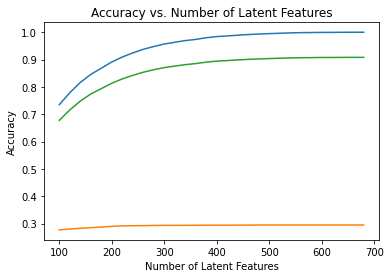

In [117]:
plt.plot(latent_features, acc_train, label="training accuracy")
plt.plot(latent_features, acc_test, label="test accuracy")
plt.plot(latent_features, acc_total, label="total accuracy")

plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')

As the above chart shows, the accuracy of test accuracy is not significantly changed after 200-300 latent features.
Because we have only 20 users in common of the training. We cannot predict for remained 662 users from test set.
But for total accuracy the model can work will with 500 latent features.

